In [2]:
!pip install spacy


In [3]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 23.4 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import pandas as pd

chemin_de_base = '/files/Project/'

try:
    # Assurez-vous que le chemin et le nom du fichier sont corrects.
    # Spécifiez 'delimiter' et 'decimal' si votre fichier utilise des formats différents pour ces éléments.
    telegram_df = pd.read_csv(chemin_de_base + 'Telegram_sentiment.csv', delimiter=';', decimal=',')
    print("Fichier importé avec succès. Aperçu des données :")
    print(telegram_df.head())  # Affiche les premières lignes pour vérifier que tout est correct.

except pd.errors.ParserError as e:
    print("Une erreur de parsing s'est produite:", e)
except FileNotFoundError as e:
    print("Fichier non trouvé:", e)
except Exception as e:
    print("Une erreur inattendue est survenue:", e)


Fichier importé avec succès. Aperçu des données :
   Column1         channel    id  \
0        0  binancesignals  1382   
1        1  binancesignals  1381   
2        2  binancesignals  1380   
3        3  binancesignals  1379   
4        4  binancesignals  1378   

                                                text              date  views  \
0           bitcoin market cap surpasses 13 trillion  04/03/2024 16:33   6319   
1  update atausdt long leverage cross x10 smashed...  04/03/2024 11:48   6847   
2  altcoins started make move bitcoin total marke...  03/03/2024 19:53   8066   
3  coin maticusdt timeframe 1d observation broken...  03/03/2024 17:52   7740   
4  coin aptusdt timeframe 1d observation broken m...  03/03/2024 17:50   7668   

                                              scores  compound sentiment_type  
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000        NEUTRAL  
1  {'neg': 0.0, 'neu': 0.751, 'pos': 0.249, 'comp...    0.5106       POSITIVE  
2  {'n

In [6]:
import pandas as pd
import spacy
from spacy.lang.en import English

# Charger le modèle Spacy
nlp = spacy.load('en_core_web_sm')

# Fonction pour tokeniser et nettoyer les données
def tokenize(text):
    # Convertir l'entrée en string si ce n'est pas déjà du texte
    text = str(text)
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return tokens

# Vérifier si le DataFrame a la colonne 'text'
if 'text' in telegram_df.columns:
    # Application de la tokenisation sur la colonne de texte
    telegram_df['tokens'] = telegram_df['text'].apply(tokenize)
else:
    print("La colonne 'text' n'existe pas dans le DataFrame.")


In [7]:
!pip install gensim

In [8]:
from gensim.corpora import Dictionary

# Créer un dictionnaire de tous les tokens
dct = Dictionary(telegram_df['tokens'])

# Filtrer les tokens qui sont trop rares ou trop fréquents
dct.filter_extremes(no_below=5, no_above=0.5)

# Créer le corpus BoW
corpus = [dct.doc2bow(text) for text in telegram_df['tokens']]


In [9]:
from gensim.models import LdaModel

# Entraîner le modèle LDA
lda_model = LdaModel(corpus=corpus, id2word=dct, num_topics=10, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)


In [10]:
#Étape 1 : Interprétation des Sujets
for i, topic in lda_model.show_topics(formatted=True, num_topics=10, num_words=10):
    print(f"Topic #{i}: {topic}\n")


Topic #0: 0.136*"market" + 0.096*"crypto" + 0.047*"ethereum" + 0.046*"divergence" + 0.044*"rsi" + 0.037*"binance" + 0.032*"average" + 0.028*"drop" + 0.023*"eth" + 0.021*"future"

Topic #1: 0.137*"day" + 0.127*"head" + 0.095*"shoulder" + 0.058*"hard" + 0.048*"inverse" + 0.047*"neckline" + 0.038*"know" + 0.036*"base" + 0.031*"nice" + 0.030*"flag"

Topic #2: 0.049*"bitcoin" + 0.043*"update" + 0.029*"u" + 0.020*"reach" + 0.019*"start" + 0.017*"not" + 0.016*"high" + 0.015*"happen" + 0.015*"week" + 0.014*"2"

Topic #3: 0.078*"go" + 0.059*"upside" + 0.050*"short" + 0.048*"prediction" + 0.043*"downside" + 0.034*"btcusdt" + 0.031*"coin" + 0.030*"look" + 0.030*"like" + 0.026*"0618"

Topic #4: 0.178*"ð" + 0.108*"â" + 0.076*"trend" + 0.035*"m" + 0.030*"triangle" + 0.027*"ðð" + 0.023*"20" + 0.017*"egldusdt" + 0.016*"âï" + 0.015*"take"

Topic #5: 0.100*"btc" + 0.031*"2023" + 0.027*"balance" + 0.026*"analysis" + 0.021*"risk" + 0.021*"discount" + 0.021*"work" + 0.021*"safe" + 0.018*"sentiment" + 0.017

In [11]:
# Exemple de mots clés associés aux cryptomonnaies
keywords_per_coin = {
    'Bitcoin': ['bitcoin', 'btc', 'BTC', 'Bitcoin', 'coin', 'BITCOIN'],
    'Ethereum': ['ethereum', 'ETH', 'Ethereum', 'eth', 'Altcoin', 'Altcoins', 'altcoins', 'altcoin'],
   
}

# Initialisation de la matrice de concepts
concept_matrix = pd.DataFrame(0, index=range(lda_model.num_topics), columns=keywords_per_coin.keys())

# Remplissage de la matrice de concepts
for topic_id in range(lda_model.num_topics):
    topic_keywords = lda_model.show_topic(topic_id)
    for word, weight in topic_keywords:
        for coin, keywords in keywords_per_coin.items():
            if word in keywords:
                concept_matrix.loc[topic_id, coin] += weight

# Affichage de la matrice de concepts pour vérifier
print(concept_matrix)

    Bitcoin  Ethereum
0  0.000000  0.070693
1  0.000000  0.000000
2  0.048641  0.000000
3  0.030579  0.000000
4  0.000000  0.000000
5  0.100396  0.000000
6  0.000000  0.000000
7  0.000000  0.000000
8  0.000000  0.000000
9  0.000000  0.000000


In [12]:
#Pour les sentiments numériques 
# Étape 1 : Créer la distribution de sujets pour chaque document
doc_topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Convertir les distributions de sujets en un DataFrame, avec un document par ligne et des sujets par colonne
doc_topics_df = pd.DataFrame([{topic: prob for topic, prob in dist} for dist in doc_topic_distributions])

# Remplir les valeurs manquantes par 0, car non tous les sujets apparaissent dans chaque document
doc_topics_df = doc_topics_df.fillna(0)

# Maintenant, nous allons créer le DataFrame 'doc_concepts'
# en utilisant la matrice de concepts que vous avez créée précédemment
# Supposons que votre matrice de concepts est nommée 'concept_matrix'
doc_concepts = doc_topics_df.dot(concept_matrix)

# Étape 2 : Intégrer les scores de sentiment dans le DataFrame 'doc_concepts'
doc_concepts['sentiment_type'] = telegram_df['sentiment_type']
doc_concepts['compound'] = telegram_df['compound']

# Vérifier les premières lignes pour s'assurer que tout a bien fonctionné
print(doc_concepts.head())


    Bitcoin  Ethereum sentiment_type  compound
0  0.013357  0.008414        NEUTRAL    0.0000
1  0.007631  0.001754       POSITIVE    0.5106
2  0.029140  0.006421        NEUTRAL    0.0000
3  0.011453  0.001513       NEGATIVE   -0.4767
4  0.016788  0.001576       NEGATIVE   -0.4767


                 Bitcoin  Ethereum
sentiment_type                    
NEGATIVE        0.016157  0.006189
NEUTRAL         0.016328  0.008733
POSITIVE        0.017566  0.007881


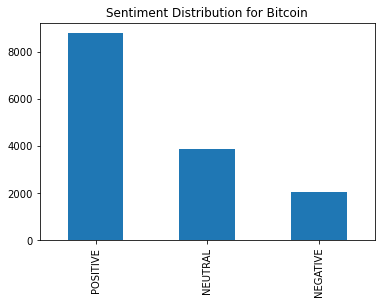

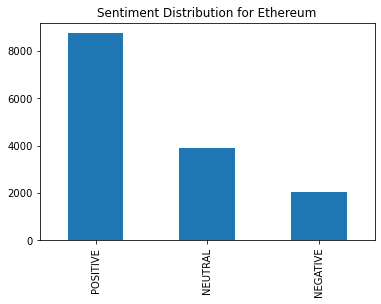

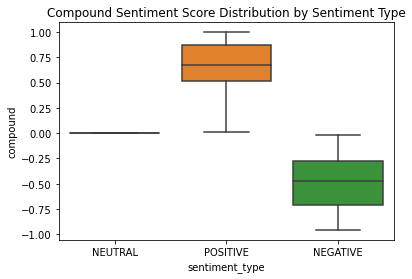

           Bitcoin  Ethereum  compound
Bitcoin   1.000000  0.066171  0.110992
Ethereum  0.066171  1.000000 -0.003636
compound  0.110992 -0.003636  1.000000


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyse de sentiment agrégée par concept
mean_sentiments_by_concept = doc_concepts.groupby('sentiment_type').mean()[['Bitcoin', 'Ethereum']]
print(mean_sentiments_by_concept)

# Distribution des types de sentiment pour Bitcoin
bitcoin_sentiment_distribution = doc_concepts['sentiment_type'][doc_concepts['Bitcoin'] > 0].value_counts()
ethereum_sentiment_distribution = doc_concepts['sentiment_type'][doc_concepts['Ethereum'] > 0].value_counts()

# Visualisation de la distribution des types de sentiment pour Bitcoin
bitcoin_sentiment_distribution.plot(kind='bar', title='Sentiment Distribution for Bitcoin')
plt.show()

# De même pour Ethereum
ethereum_sentiment_distribution.plot(kind='bar', title='Sentiment Distribution for Ethereum')
plt.show()

# Boxplot pour visualiser la distribution des scores compound par cryptomonnaie
sns.boxplot(x='sentiment_type', y='compound', data=doc_concepts)
plt.title('Compound Sentiment Score Distribution by Sentiment Type')
plt.show()

# Vous pouvez aussi calculer la corrélation entre les scores compound et la présence des concepts
correlation_matrix = doc_concepts[['Bitcoin', 'Ethereum', 'compound']].corr()
print(correlation_matrix)


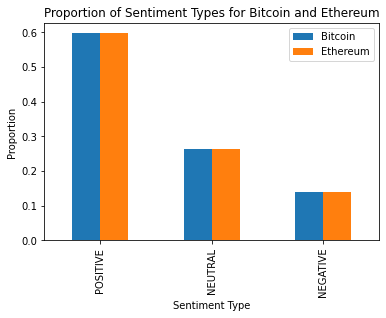

In [14]:
# Calculer le nombre de mentions positives, neutres et négatives pour Bitcoin et Ethereum
bitcoin_sentiments = doc_concepts[doc_concepts['Bitcoin'] > 0]['sentiment_type'].value_counts()
ethereum_sentiments = doc_concepts[doc_concepts['Ethereum'] > 0]['sentiment_type'].value_counts()

# Créer un DataFrame pour comparer les résultats
sentiment_comparison = pd.DataFrame({
    'Bitcoin': bitcoin_sentiments,
    'Ethereum': ethereum_sentiments
})

# Normaliser les comptes par le total des mentions pour chaque cryptomonnaie
# pour obtenir des proportions au lieu de nombres absolus
sentiment_comparison = sentiment_comparison.div(sentiment_comparison.sum(axis=0), axis=1)

# Visualisation de la comparaison
sentiment_comparison.plot(kind='bar', title='Proportion of Sentiment Types for Bitcoin and Ethereum')
plt.xlabel('Sentiment Type')
plt.ylabel('Proportion')
plt.show()


           Bitcoin  Ethereum  compound
Bitcoin   1.000000  0.066171  0.110992
Ethereum  0.066171  1.000000 -0.003636
compound  0.110992 -0.003636  1.000000


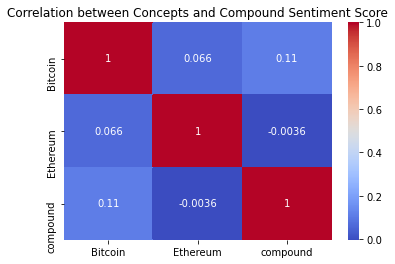

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que 'doc_concepts' est votre DataFrame contenant les concepts et les scores compound
correlation_matrix = doc_concepts[['Bitcoin', 'Ethereum', 'compound']].corr()

# Affichage de la matrice de corrélation
print(correlation_matrix)

# Visualisation de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Concepts and Compound Sentiment Score')
plt.show()


In [17]:
keywords_per_concept = {
    'Blockchain': ['blockchain', 'smart contract', 'consensus', 'hash rate'],
    'Security': ['security', 'hack', 'encryption', 'wallet'],
    'Regulations': ['regulation', 'SEC', 'law', 'compliance'],
    'Trading': ['trading', 'investment', 'market', 'bull', 'bear'],
    'Adoption': ['adoption', 'transaction', 'payment', 'retail'],
    'Innovation': ['update', 'upgrade', 'innovation', 'development']
}

# Initialisation de la matrice de concepts
concept_matrix = pd.DataFrame(0, index=range(lda_model.num_topics), columns=keywords_per_concept.keys())

# Remplissage de la matrice de concepts
for topic_id in range(lda_model.num_topics):
    topic_keywords = lda_model.show_topic(topic_id)
    for word, weight in topic_keywords:
        for concept, keywords in keywords_per_concept.items():
            if word in keywords:
                concept_matrix.loc[topic_id, concept] += weight


In [23]:
# Création du DataFrame pour les distributions des sujets par document
doc_topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]
doc_topics_df = pd.DataFrame([{topic: prob for topic, prob in dist} for dist in doc_topic_distributions]).fillna(0)

# Utilisation de la matrice de concepts pour transformer les distributions de sujets en distributions de concepts
doc_concepts = doc_topics_df.dot(concept_matrix)

# Affichage des premières lignes pour vérifier la distribution des concepts
print(doc_concepts.head())


   Blockchain  Security  Regulations   Trading  Adoption  Innovation
0         0.0       0.0          0.0  0.016176       0.0    0.007679
1         0.0       0.0          0.0  0.003372       0.0    0.004287
2         0.0       0.0          0.0  0.012343       0.0    0.021006
3         0.0       0.0          0.0  0.002908       0.0    0.004968
4         0.0       0.0          0.0  0.003030       0.0    0.003323


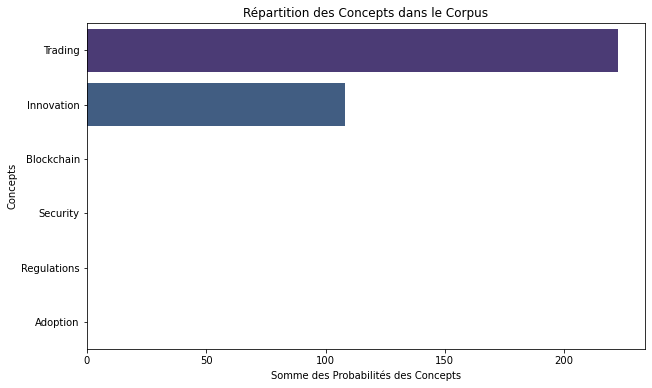

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Somme des contributions de chaque concept à travers tous les documents
concept_sums = doc_concepts.sum().sort_values(ascending=False)

# Bar plot des sommes des concepts
plt.figure(figsize=(10, 6))
sns.barplot(x=concept_sums.values, y=concept_sums.index, palette='viridis')
plt.title('Répartition des Concepts dans le Corpus')
plt.xlabel('Somme des Probabilités des Concepts')
plt.ylabel('Concepts')
plt.show()


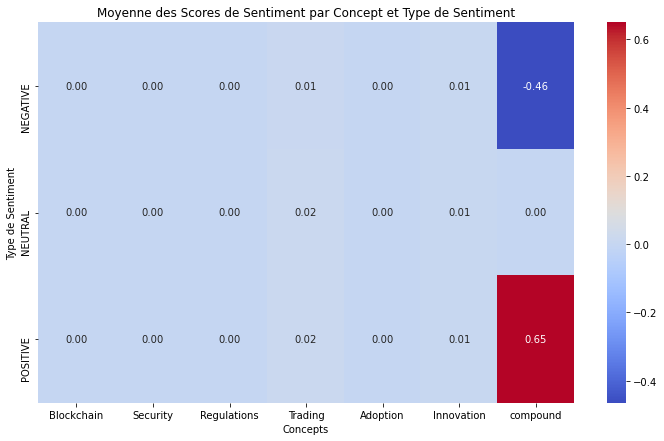

In [26]:
# Ajouter les colonnes de sentiments au DataFrame `doc_concepts`
doc_concepts['sentiment_type'] = telegram_df['sentiment_type']
doc_concepts['compound'] = telegram_df['compound']

# Calculer la moyenne des scores de sentiment pour chaque concept
mean_sentiments_by_concept = doc_concepts.groupby('sentiment_type').mean()

# Visualisation
plt.figure(figsize=(12, 7))
sns.heatmap(mean_sentiments_by_concept, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Moyenne des Scores de Sentiment par Concept et Type de Sentiment')
plt.ylabel('Type de Sentiment')
plt.xlabel('Concepts')
plt.show()


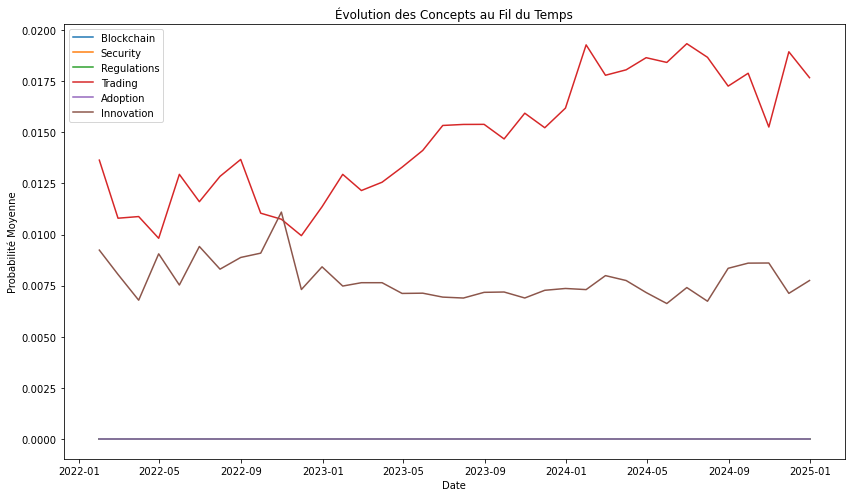

In [27]:
# Ajouter une colonne de date au DataFrame `doc_concepts`
doc_concepts['date'] = pd.to_datetime(telegram_df['date'])

# Grouper par mois ou année selon le besoin
grouped_by_date = doc_concepts.resample('M', on='date').mean()

# Visualisation de l'évolution des concepts
plt.figure(figsize=(14, 8))
for concept in concept_matrix.columns:
    plt.plot(grouped_by_date.index, grouped_by_date[concept], label=concept)

plt.title('Évolution des Concepts au Fil du Temps')
plt.xlabel('Date')
plt.ylabel('Probabilité Moyenne')
plt.legend()
plt.show()


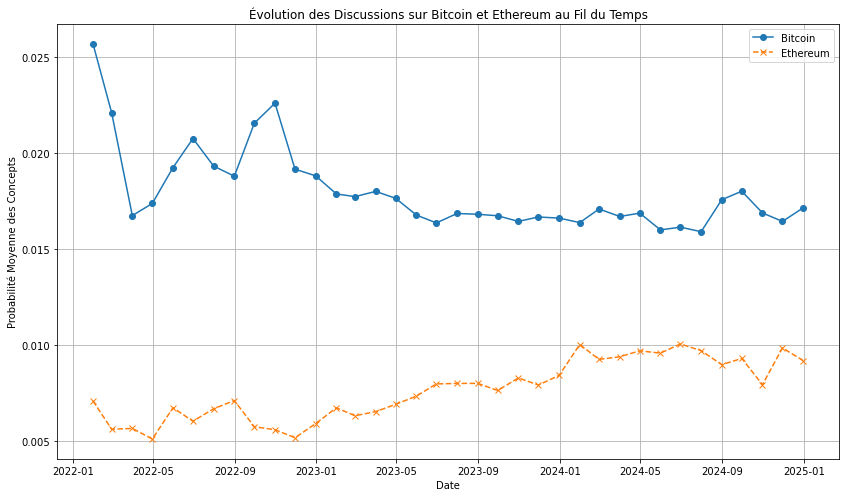

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Supposons que telegram_df est déjà chargé avec les colonnes 'tokens' et 'date'

# Créer un dictionnaire de tous les tokens
dct = Dictionary(telegram_df['tokens'])

# Filtrer les tokens qui sont trop rares ou trop fréquents
dct.filter_extremes(no_below=5, no_above=0.5)

# Créer le corpus BoW
corpus = [dct.doc2bow(text) for text in telegram_df['tokens']]

# Entraîner le modèle LDA
lda_model = LdaModel(corpus=corpus, id2word=dct, num_topics=10, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Initialisation de la matrice de concepts pour Bitcoin et Ethereum
keywords_per_coin = {
    'Bitcoin': ['bitcoin', 'btc', 'BTC', 'Bitcoin', 'coin', 'BITCOIN'],
    'Ethereum': ['ethereum', 'ETH', 'Ethereum', 'eth', 'Altcoin', 'Altcoins', 'altcoins', 'altcoin'],
}

concept_matrix = pd.DataFrame(0, index=range(lda_model.num_topics), columns=keywords_per_coin.keys())

# Remplissage de la matrice de concepts
for topic_id in range(lda_model.num_topics):
    topic_keywords = lda_model.show_topic(topic_id)
    for word, weight in topic_keywords:
        for coin, keywords in keywords_per_coin.items():
            if word in keywords:
                concept_matrix.loc[topic_id, coin] += weight

# Création du DataFrame pour les distributions des sujets par document
doc_topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]
doc_topics_df = pd.DataFrame([{topic: prob for topic, prob in dist} for dist in doc_topic_distributions]).fillna(0)

# Utilisation de la matrice de concepts pour transformer les distributions de sujets en distributions de concepts
doc_concepts = doc_topics_df.dot(concept_matrix)

# Ajouter la colonne de date
doc_concepts['date'] = pd.to_datetime(telegram_df['date'])

# Grouper par mois
grouped_by_date = doc_concepts.resample('M', on='date').mean()

# Visualisation de l'évolution des concepts de Bitcoin et Ethereum
plt.figure(figsize=(14, 8))
plt.plot(grouped_by_date.index, grouped_by_date['Bitcoin'], label='Bitcoin', marker='o', linestyle='-')
plt.plot(grouped_by_date.index, grouped_by_date['Ethereum'], label='Ethereum', marker='x', linestyle='--')

plt.title('Évolution des Discussions sur Bitcoin et Ethereum au Fil du Temps')
plt.xlabel('Date')
plt.ylabel('Probabilité Moyenne des Concepts')
plt.legend()
plt.grid(True)
plt.show()




In [38]:
!pip install gensim

In [39]:
import gensim.downloader as api

# Charger le modèle GloVe adapté
glove_model = api.load("glove-twitter-50")  # Modèle de base sur des tweets



In [41]:
import gensim

def preprocess(text):
    # Convertir l'entrée en string si ce n'est pas déjà du texte
    text = str(text) if not pd.isna(text) else ""

    # Tokenisation et nettoyage du texte
    tokens = gensim.utils.simple_preprocess(text)

    # Filtrer les mots hors du vocabulaire de GloVe
    tokens = [word for word in tokens if word in glove_model.key_to_index]
    return tokens

# Application du prétraitement sur le DataFrame
telegram_df['processed_tokens'] = telegram_df['text'].apply(preprocess)


In [42]:
import numpy as np

def document_vector(tokens):
    # Calculer le vecteur moyen pour les tokens d'un document
    vectors = [glove_model[token] for token in tokens if token in glove_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(glove_model.vector_size)

telegram_df['doc_vector'] = telegram_df['processed_tokens'].apply(document_vector)


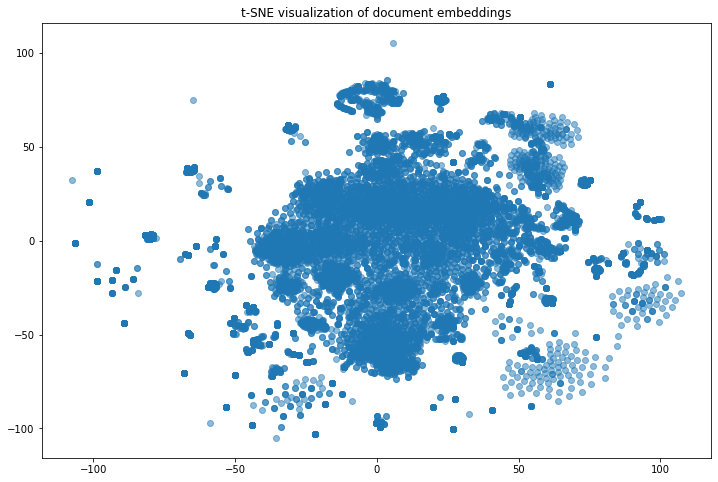

In [44]:

import numpy as np
from sklearn.manifold import TSNE

# Assurez-vous que 'doc_vector' est une liste d'arrays Numpy ou un DataFrame pandas.
# Si 'doc_vector' est une série d'arrays (ou de listes), vous pouvez la convertir comme suit :
vectors = np.array(list(telegram_df['doc_vector'].values))

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(vectors)  # Utilisez `vectors` qui est maintenant un array de Numpy

# Visualisation des embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.5)
plt.title('t-SNE visualization of document embeddings')
plt.show()
import numpy as np
from sklearn.manifold import TSNE


In [48]:
#Identifier des Clusters

from sklearn.cluster import KMeans

# Choisissez un nombre de clusters K après évaluation, ou utilisez des méthodes comme la méthode du coude pour le déterminer
k = 5  # Par exemple, nous choisissons 5 clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Définition explicite de n_init
cluster_labels = kmeans.fit_predict(embeddings)

# Ajoutez les étiquettes de cluster au DataFrame pour une analyse ultérieure
telegram_df['cluster'] = cluster_labels



In [50]:
#Analyser les Clusters

for i in range(k):
    print(f"Cluster {i}:")
    print(telegram_df[telegram_df['cluster'] == i]['text'].sample(5), '\n')  # Affiche un échantillon de textes de chaque cluster


Cluster 0:
3238    ðsignal id 1194ð coin icpusdt 510x direction l...
3006    ðsignal id 1169ð coin adausdt 35x direction lo...
832     update chrusdt currently profit feel nice catc...
7353    ðavaxusdt long leverage 1x target 1610â 1750â ...
2610    ðsignal id 1276ð coin zilusdt 35x direction lo...
Name: text, dtype: object 

Cluster 1:
11074     crypto fear greed chart verified crypto trader â
2304                                          â â sushiâ â
4002     bkâ crypto fear greed index âââââââ tmebinance...
2389     vip crypto market rsi heatmap timeframe daily ...
5305                                          âïâïhbarâïâï
Name: text, dtype: object 

Cluster 2:
7881                                               rose ðð
11939    coin xrpusdt timeframe 1d observation still ti...
4499     top gainer analysis rei âââââââ weekly timefra...
4426     â ïvip market updateâ ï âââââââ week mother vo...
3761     september 7 2023 âââââââ market analysis marke...
Name: text, dtype: object 

Clu

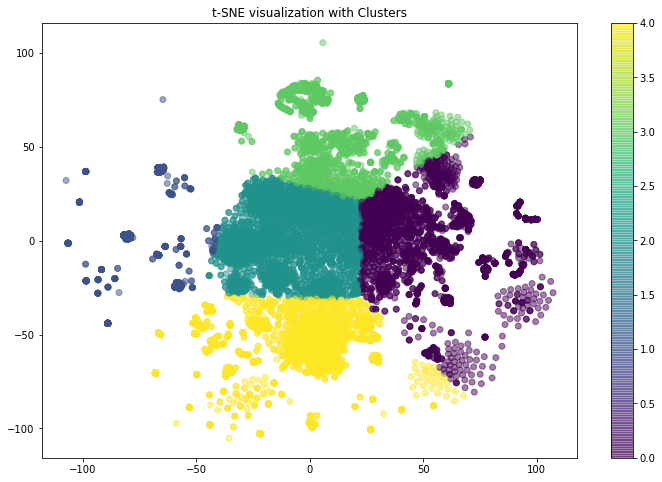

In [51]:
#Annoter le Graphique

plt.figure(figsize=(12, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE visualization with Clusters')
plt.colorbar()
plt.show()


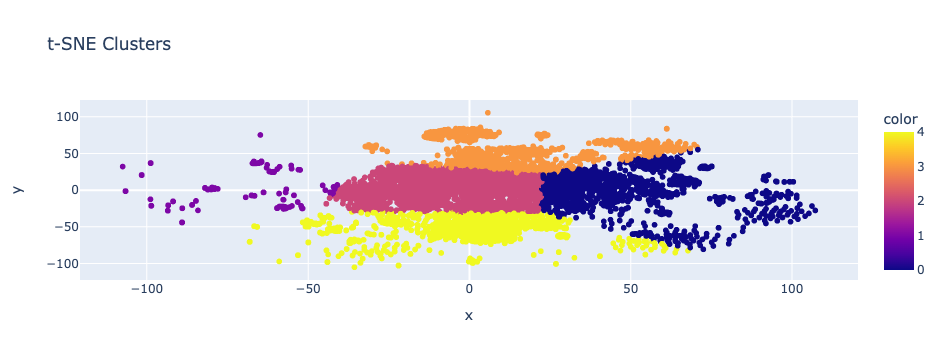

In [52]:
#Interaction avec la Visualisation

import plotly.express as px

fig = px.scatter(x=embeddings[:, 0], y=embeddings[:, 1], color=cluster_labels, title="t-SNE Clusters")
fig.show()


In [54]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(vectors, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")



Silhouette Score: 0.0858825055277979


In [55]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(vectors, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 3.557446428333815


In [73]:
#Identifier des Clusters

from sklearn.cluster import KMeans

# Choisissez un nombre de clusters K après évaluation, ou utilisez des méthodes comme la méthode du coude pour le déterminer
k = 20  # Par exemple, nous choisissons 5 clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Définition explicite de n_init
cluster_labels = kmeans.fit_predict(embeddings)

# Ajoutez les étiquettes de cluster au DataFrame pour une analyse ultérieure
telegram_df['cluster'] = cluster_labels



In [74]:
#Analyser les Clusters

for i in range(k):
    print(f"Cluster {i}:")
    print(telegram_df[telegram_df['cluster'] == i]['text'].sample(5), '\n')  # Affiche un échantillon de textes de chaque cluster


Cluster 0:
7059                      xmrâ â
3665                âïâïlinkâïâï
1149                          ðð
14040                ethereum ðð
11289    httpsyoutubeuvbii6uxxr0
Name: text, dtype: object 

Cluster 1:
7674     ðsxpusdt long leverage 13x target 0272â 029â 0...
7937     ðoneusdt long leverage 510x target â 000954 â ...
6591     ðyfiusdt long leverage 510x target 7500â 7600â...
7724     ðjasmyusdt long leverage 23x target 000313â 00...
13456                     cointelegraph spreaded fake news
Name: text, dtype: object 

Cluster 2:
13197    coin pumping today layer buy hold massive prof...
14296    shorting hntusdt x5 leverage minimise risk ent...
1208                                       second target ð
13709    minausdt update followed prediction went 40 pr...
12327    update etcusdt timeframe 4hr observation follo...
Name: text, dtype: object 

Cluster 3:
123     coin gtcusdt timeframe 1d observation currentl...
4252    top gainer analysis rei âââââââ pumped hard hi...
3

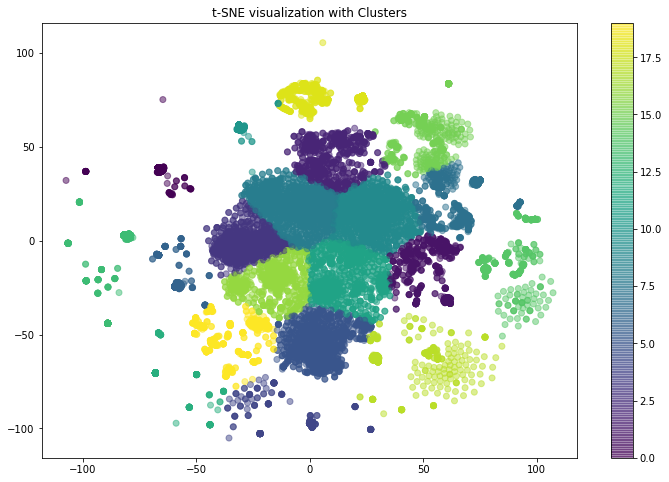

In [75]:
#Annoter le Graphique

plt.figure(figsize=(12, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE visualization with Clusters')
plt.colorbar()
plt.show()

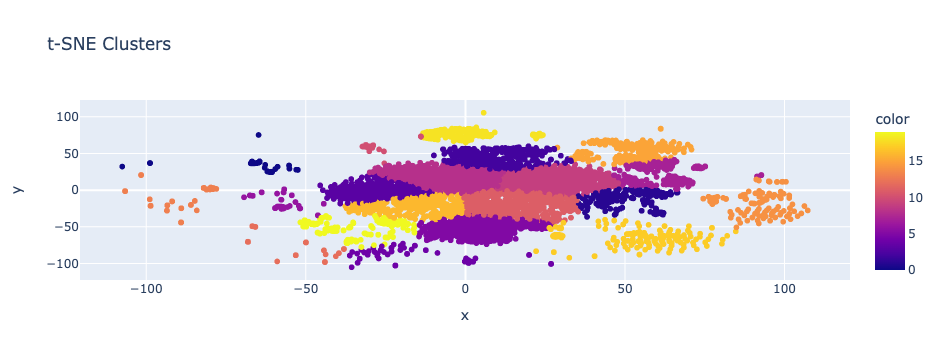

In [76]:
#Interaction avec la Visualisation

import plotly.express as px

fig = px.scatter(x=embeddings[:, 0], y=embeddings[:, 1], color=cluster_labels, title="t-SNE Clusters")
fig.show()

In [77]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(vectors, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")



Silhouette Score: 0.1698031930506099


In [78]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(vectors, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 2.6052400172832915
